# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math

In [2]:
df = pd.read_csv('reviews_full_v7.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
df['Genre']

0        technical thrash metal|math metal|progressive ...
1                            grindcore|melodic death metal
2                                    symphonic power metal
3                               heavy metal|us power metal
4                                              power metal
                               ...                        
93429                                         thrash metal
93430                                          death metal
93431                                         thrash metal
93432                                            hard rock
93433                                            hard rock
Name: Genre, Length: 93434, dtype: object

In [5]:
G = nx.Graph()
B = nx.Graph()

In [6]:
genres = open('genres.txt').read().split('\n')[:-1] #nodes, lastline is newspace
len(genres)

297

In [7]:
#construction of bipartite graph
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    for genre in genre_list:
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
        else:
            B.add_edge(user, genre, weight = 1)

In [8]:
B.number_of_nodes()

8344

In [9]:
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        w = B[genre1][user]['weight']
        for genre2 in B.adj[user]:
            #the weight of the edge is determined as the minimum weights of the two edges in bipartite graph
            w = min(w,B[genre2][user]['weight'])
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += w
            else:
                G.add_edge(genre1, genre2, weight = w)

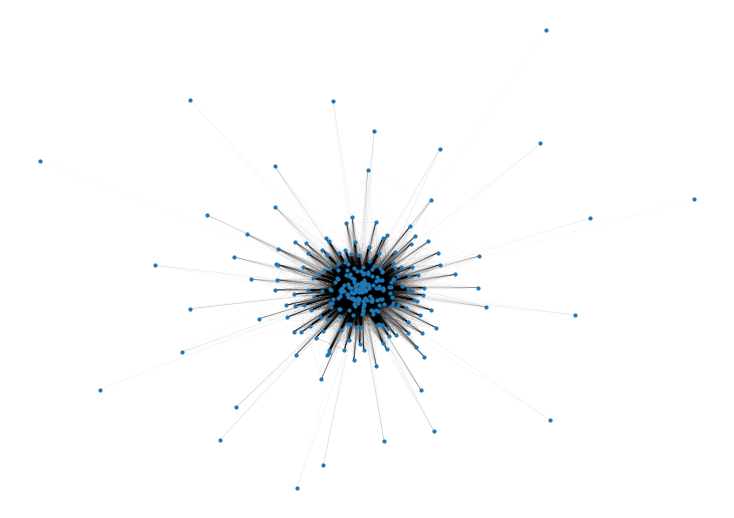

In [10]:
weights = np.array(list(nx.get_edge_attributes(G,'weight').values()))/100
nx.draw(G, node_size = 10, width = list(weights))

(array([2.0502e+04, 6.5000e+01, 1.9000e+01, 3.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 5.5760e+02, 1.1142e+03, 1.6708e+03, 2.2274e+03,
        2.7840e+03, 3.3406e+03, 3.8972e+03, 4.4538e+03, 5.0104e+03,
        5.5670e+03]),
 <a list of 10 Patch objects>)

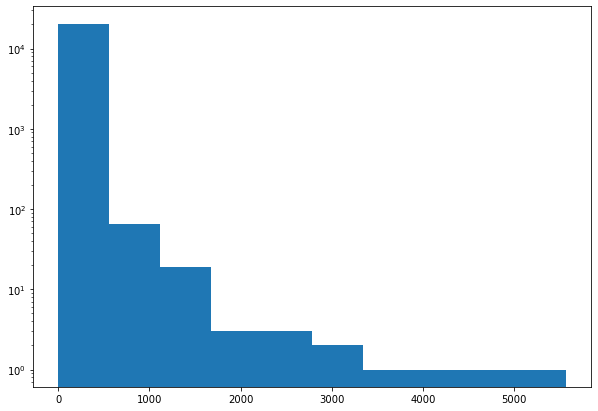

In [11]:
plt.hist(list(nx.get_edge_attributes(G,'weight').values()), log = True)

In [12]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

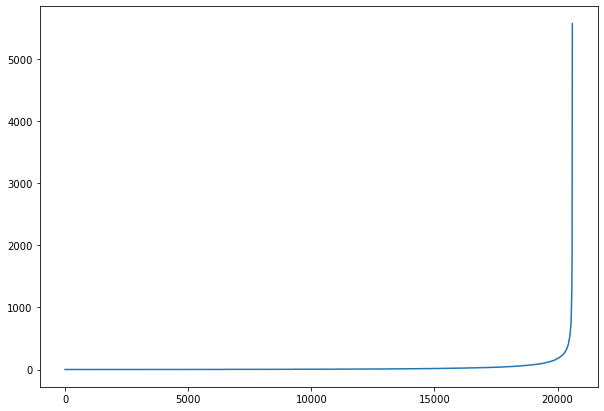

In [13]:
plt.plot(sorted(list(nx.get_edge_attributes(G,'weight').values())))
plt.show()

In [14]:
tmp = sorted(list(nx.get_edge_attributes(G,'weight').values()))
'''plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

'plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()'

In [15]:
tmp[10000]

6

In [16]:
G2 = G.copy()
for u,v in G2.edges():
    if G2[u][v]['weight'] < 10:
        G.remove_edge(u,v)
nx.number_connected_components(G)
print(clt.Counter([len(cc) for cc in nx.connected_components(G)]))
print(list(nx.isolates(G)))

Counter({1: 85, 204: 1})
['ambient folk', 'electronic symphonic metal', 'punk rock', 'experimental jazz', 'melodic rock', 'industrial rock', 'neo-classical power heavy metal', 'pagan metal', 'pop rock', 'epic folk', 'psychedelic sludge metal', 'blackened stoner metal', 'neoclassical progressive metal', 'celtic black metal', 'country rock', 'viking metal', 'jazz rock', 'gothic death metal', 'nu thrash metal', 'experimental grindcore', 'country', 'noise rock', 'acoustic folk', 'electronic', 'dance', 'experimental progressive metal', 'neoclassical darkwave', 'stoner doom metal', 'ebm', 'industrial', 'synth pop', 'electronic industrial metal', 'epic black metal', 'jazz fusion', 'free jazz', 'crust', 'atmospheric progressive metal', 'medieval folk metal', 'accustic', 'sludge doom metal', 'darkwave', 'trip-hop', 'celtic doom metal', 'gothic folk metal', 'blackened industrial metal', 'new age', 'contemporary folk', 'instrumental power metal', 'ambient noise', 'electro', 'experimental thrash m

In [17]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [18]:
G2 = G.copy()
for node in G2.nodes():
    if node not in genre_group:
        print(node)
    if node not in genre_group or genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)

pagan metal
experimental metal


In [19]:
'''tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]
mp = {}
for genre in tmp:
    for item in genre[1:]:
        mp[item] = genre[0]
pickle.dump(mp,open('genre_group.p','wb'))
f = open('genres.txt').read().split('\n')[:-1]
for item in f:
    if item not in genre_group:
        print(item)'''

"tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]\nmp = {}\nfor genre in tmp:\n    for item in genre[1:]:\n        mp[item] = genre[0]\npickle.dump(mp,open('genre_group.p','wb'))\nf = open('genres.txt').read().split('\n')[:-1]\nfor item in f:\n    if item not in genre_group:\n        print(item)"

In [20]:
def freq_network_parr(Graph, n_iter, n_jobs):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = 'weight') for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v]['weight'] += 1
                else:
                    G.add_edge(u,v,weight = 1)
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [21]:
H = G.copy()
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

44 10440 4979
1 10440 4775
1 10440 4775
4 3271 2809
4 3271 2809
5 2578 2578


In [22]:
partitions = [cc for cc in nx.connected_components(H)]

In [33]:
def getScore(Graph):
    comps = list(nx.connected_components(Graph))
    subgraphs = [G.subgraph(comp) for comp in comps]
    total = [sum([G[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    #total = [sum([G[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    return total
getScore(H)

[123.18333333333332,
 691.0952380952381,
 65.62916291629146,
 248.0082644628097,
 43.11111111111116]

In [36]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
genData(H,1)

,Genres,Sizes,Average_Weight
0,"{metalcore, technical death metal, extreme ind...",21,123.183333
1,"{black doom metal, technical black metal, prog...",11,691.095238
2,"{psychedelic doom metal, neofolk, psychedelic ...",55,65.629163
3,"{symphonic doom metal, technical metalcore, sy...",25,248.008264
4,"{melodic progressive metal, melodic thrash met...",33,43.111111


In [37]:
[len(cc) for cc in nx.connected_components(H)]

[21, 11, 55, 25, 33]

In [39]:
print(list(nx.connected_components(H))[2])

{'psychedelic doom metal', 'neofolk', 'psychedelic black metal', 'atmospheric sludge metal', 'post-metal', 'extreme avantgarde metal', 'experimental death metal', 'extreme sludge metal', 'symphonic black metal', 'gothic metal', 'pagan black metal', 'folk doom metal', 'shoegaze', 'extreme folk metal', 'folk', 'extreme progressive metal', 'experimental black metal', 'funeral doom metal', 'atmospheric black metal', 'avantgarde black metal', 'gothic doom metal', 'instrumental post-metal', 'atmospheric gothic metal', 'ambient black metal', 'viking black metal', 'pagan folk metal', 'avantgarde metal', 'folk metal', 'atmospheric doom metal', 'ambient doom metal', 'industrial death metal', 'industrial black metal', 'stoner rock', 'gothic rock', 'depressive black metal', 'folk rock', 'celtic folk metal', 'doom death metal', 'death doom metal', 'blackened death metal', 'melodic black metal', 'blackened sludge metal', 'blackened doom metal', 'sludge metal', 'symphonic death metal', 'melodic doom 

In [40]:
G1 = G.subgraph(list(nx.connected_components(H))[2])
while not no_crossedges(G1):
    G1 = freq_network_parr(G1, 100, 4)

1 1485 1111
1 1485 335
1 1485 335
5 282 282


In [41]:
tmp1 = list(nx.connected_components(G1))
[len(cc) for cc in tmp1]

[13, 12, 9, 12, 9]

In [42]:
genData(G1,'2-2')

,Genres,Sizes,Average_Weight
0,"{blackened death metal, psychedelic black meta...",13,60.365854
1,"{death doom metal, atmospheric doom metal, bla...",12,73.854545
2,"{folk metal, melodic black metal, viking folk ...",9,96.166667
3,"{psychedelic doom metal, neofolk, funeral doom...",12,92.281690
4,"{blackened sludge metal, sludge metal, extreme...",9,173.852941


In [43]:
G1 = G.subgraph(list(nx.connected_components(H))[4])
while not no_crossedges(G1):
    G1 = freq_network_parr(G1, 100, 4)

1 528 432
3 382 93
3 382 93
9 57 57


In [46]:
genData(G1,'2-4')

,Genres,Sizes,Average_Weight
0,"{symphonic progressive metal, melodic power me...",7,34.428571
1,"{extreme gothic metal, symphonic gothic metal,...",4,98.444444
2,"{first wave of black metal, us industrial meta...",6,82.250000
3,"{epic doom metal, melodic thrash metal}",2,91.666667
4,"{technical thrash metal, progressive thrash me...",3,108.666667
5,"{melodic metalcore, deathcore}",2,139.666667
6,"{crossover thrash metal, blackened thrash metal}",2,195.666667
7,"{neoclassical heavy metal, groove metal, alter...",4,71.000000
8,"{industrial thrash metal, depressive heavy met...",3,60.600000


In [45]:
total = [G[u][v]['weight'] for u,v in G.subgraph(tmp1[3]).edges()]
sum(total)/len(total)

92.28169014084507

In [ ]:
tmp1[3]